In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
# Build the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(stoi)

print ( itos )

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# Build the dataset
block_size = 3

def build_dataset(words):
    X,Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# Init the parameters

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.rand((n_embed*block_size,n_hidden), generator=g) * 0.1
b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters)

11897

In [6]:
# Forward pass
losses = []
steps = []
batch_size = 32
max_steps = 200000
for i in range(max_steps):
    
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy( logits, Ytr[ix] )

    # Backwards pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    ## Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    losses.append(loss.log10().item())
    steps.append(i)
    
    if i % 10000 == 0:
        print ( f'{i:7d}/{max_steps:7d}: {loss.item():0.4f}' )

      0/ 200000: 3.2843
  10000/ 200000: 2.1754
  20000/ 200000: 2.0029
  30000/ 200000: 2.4850
  40000/ 200000: 2.2604
  50000/ 200000: 1.9757
  60000/ 200000: 1.6257
  70000/ 200000: 2.5106
  80000/ 200000: 1.6836
  90000/ 200000: 2.3828
 100000/ 200000: 2.2367
 110000/ 200000: 2.3063
 120000/ 200000: 1.6502
 130000/ 200000: 2.0361
 140000/ 200000: 2.2512
 150000/ 200000: 1.8978
 160000/ 200000: 1.8471
 170000/ 200000: 1.8883
 180000/ 200000: 2.0192
 190000/ 200000: 2.1342


2.0885884761810303


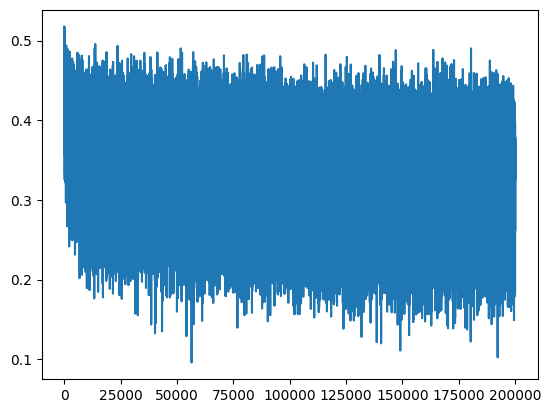

In [7]:
plt.plot( steps, losses )

# Print loss over dev dataset
emb = C[Xtr]
embcat = emb.view(emb.shape[0], -1)
h = torch.tanh(embcat @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy( logits, Ytr )
print ( loss.item() )

In [8]:
# Print loss over all datasets
@torch.no_grad()
def split_loss( split ):
    X,Y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy( logits, Y )
    print ( loss.item() )
    
split_loss( 'train' )
split_loss( 'val' )
split_loss( 'test' )

2.0885884761810303
2.127884864807129
2.1255300045013428


In [9]:
g = torch.Generator().manual_seed(2147483647)
                                  
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1,30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ( ix == 0 ):
            break
    print( ''.join(itos[i] for i in out))
                  

junide.
janasir.
presayven.
makshir.
tophia.
juez.
kalinaauriana.
vias.
dedailetie.
les.
jaiely.
arte.
fartum.
kyn.
demmere.
nastinoriann.
core.
yaelon.
kaelandreed.
miki.


In [10]:
#https://youtu.be/P6sfmUTpUmc?t=1696